In [19]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_colwidth = 1000

In [20]:
import json
from bs4 import BeautifulSoup
import re


def clean_text(raw_text: str) -> str:
    if raw_text is None:
        return ''

    soup = BeautifulSoup(raw_text, features="html.parser")
    raw_text = soup.get_text()
    raw_text = raw_text.replace('\n', ' ').replace('\xa0', ' ')
    return raw_text


def read_json_as_df(path: str) -> pd.DataFrame:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append([clean_text(data['post'].get('body', None)),
                              data['priority']])

    df = pd.DataFrame(data=json_data, columns=('text', 'priority'))

    return df

def read_json_text(path: str, tag: str) -> list:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append(clean_text(data.get(tag, None)))

    return json_data

In [21]:
from sklearn.metrics import classification_report, f1_score


def print_results(true_labels, predictions):
    
    print('\n\033[1m-----------Full Classification Report-----------\033[0m\n')
    print(classification_report(true_labels, predictions))
    
    
    print("\n\033[1m------OFFICIAL - ignoring 'green' priority------\033[0m\n")
    print('\tMacro avgd f1 score: ', f1_score(true_labels, predictions, labels=['escalate', 'red', 'amber'], average='macro'))
    
    
    print("\n\033[1m----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----\033[0m\n")
    def map_flagged(label):
        if label in ['escalate', 'red', 'amber']:
            return 'flagged'
        elif label == 'green':
            return 'green'

    flagged_ytest = list(map(map_flagged, true_labels))
    flagged_predictions = list(map(map_flagged, predictions))

    print(classification_report(flagged_ytest, flagged_predictions))
    
    print("\n\033[1m----URGENT - 'red + escalate' as urgent vs 'amber + green' as non_urgent-----\033[0m\n")
    def map_urgent(label):
        if label in ['escalate', 'red']:
            return 'urgent'
        elif label in ['green', 'amber']:
            return 'non-urgent'

    urgent_ytest = list(map(map_urgent, true_labels))
    urgent_predictions = list(map(map_urgent, predictions))

    print(classification_report(urgent_ytest, urgent_predictions))


In [22]:
train_df = read_json_as_df('../Data/clpsych16-train.json')
test_df = read_json_as_df('../Data/clpsych16-test.json')

In [23]:
# train_df.text = train_df.text.str.strip()
train_df = train_df[train_df.text != '']

# test_df.text = test_df.text.str.strip()
test_df = test_df[test_df.text != '']

Mean: 406.19279661016947 
Median: 214.5 
Std: 590.8579933773781 


{'whiskers': [<matplotlib.lines.Line2D at 0x2a99725fe80>,
 'caps': [<matplotlib.lines.Line2D at 0x2a99725f5f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a997243ba8>],
 'medians': [<matplotlib.lines.Line2D at 0x2a9972251d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a997225550>],
 'means': []}

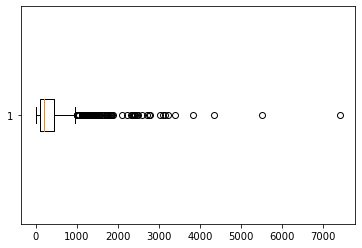

In [24]:
text_lengths = np.array([len(sent) for sent in train_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths, vert=False)

Mean: 398.25 
Median: 244.5 
Std: 508.71836101455324 


{'whiskers': [<matplotlib.lines.Line2D at 0x2a99c740198>,
 'caps': [<matplotlib.lines.Line2D at 0x2a99c740898>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a99c740048>],
 'medians': [<matplotlib.lines.Line2D at 0x2a99c740f98>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a99c74a358>],
 'means': []}

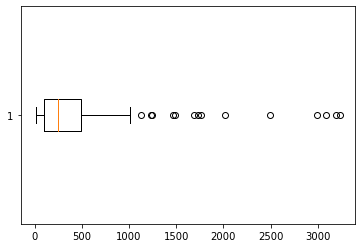

In [25]:
text_lengths = np.array([len(sent) for sent in test_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths, vert=False)

In [26]:
print(train_df.shape)
print(test_df.shape)

(944, 2)
(240, 2)


In [9]:
train_df.priority.value_counts()

green       545
amber       249
red         110
escalate     39
Name: priority, dtype: int64

In [10]:
test_df.priority.value_counts()

green       165
amber        47
red          27
escalate      1
Name: priority, dtype: int64

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))

# Initial model creation without using test set

In [12]:
features = vectorizer.fit_transform(train_df.text)
test_features = vectorizer.transform(test_df.text)

In [13]:
features.shape

(943, 5375)

In [14]:
test_features.shape

(240, 5375)

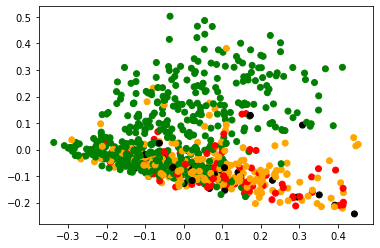

In [15]:
dense_features = features.todense()

pca = PCA(n_components=2).fit(dense_features)

features_2d = pca.transform(dense_features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

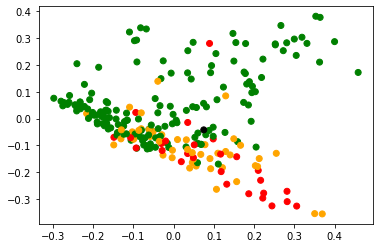

In [16]:
dense_test_features = test_features.todense()

pca = PCA(n_components=2).fit(dense_test_features)

features_2d = pca.transform(dense_test_features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

# SVC 

In [17]:
%%time

params = {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced']}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=10,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=100,
                         verbose=5)

searched_clf = clf.fit(features, train_df.priority)

print('Best Params:', searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', searched_clf.best_score_, '\n')
print(searched_clf.best_estimator_, '\n')



Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   15.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   24.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   28.7s finished


Best Params: {'C': 14.501895363648549, 'class_weight': 'balanced', 'gamma': 0.014934138054645505, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.521277531397794 

SVC(C=14.501895363648549, class_weight='balanced', gamma=0.014934138054645505) 

Wall time: 29.2 s


In [18]:
predicted_priority = searched_clf.predict(test_features)    
print_results(test_df.priority, predicted_priority)


-----------Full Classification Report-----------

              precision    recall  f1-score   support

       amber       0.53      0.62      0.57        47
    escalate       0.00      0.00      0.00         1
       green       0.95      0.87      0.91       165
         red       0.55      0.63      0.59        27

    accuracy                           0.79       240
   macro avg       0.51      0.53      0.52       240
weighted avg       0.82      0.79      0.80       240


------OFFICIAL - ignoring 'green' priority------

	Macro avgd f1 score:  0.38494478251070535

----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----

              precision    recall  f1-score   support

     flagged       0.76      0.89      0.82        75
       green       0.95      0.87      0.91       165

    accuracy                           0.88       240
   macro avg       0.85      0.88      0.87       240
weighted avg       0.89      0.88      0.88       240


----URGENT - 'red + escalat